# Galaxy Classification
This notebook uses the fastai package (built on PyTorch) as well as the sklearn package to create a machine learning model to classify images of galaxies.

This notebook also makes sue of Nvidia CUDA, a program which, in this case, allows the model to directly utilize the CUDA cores of a PC's Graphics Processing Unit (GPU). This increases the speed of the model as the GPU can more effectively handle batches of galaxy images than the CPU can.

In [1]:
import pandas as pd
from pathlib import Path
from shutil import copy
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import torch

#ONLY USE BELOW CODE IF USING GPU FOR ADDITONAL HORSEPOWER
print(torch.cuda.is_available())  # Should print True if GPU is enabled
print(torch.cuda.get_device_name(0))  # Shows the name of your GPU

True
NVIDIA GeForce RTX 3070


## Quick pre-processing

Not a lot of pre-processing is necessary. The only aspect that is important is to ensure that no truncated images (images that won't open properly) make it into either the training session or the final data classification, or else the model will crash and waste a lot of time. Alternatively, a try() catch() could be used in the final model, but I prefer to just remove the trouble images outright to prevent any trouble. The following code will identify and delete images that do not open.

In [2]:
from PIL import Image

# Path to your dataset
dataset_path = Path('ims')

# List to store corrupted file paths
corrupted_files = []

# Check all image files in the folder
for img_path in dataset_path.iterdir():
    try:
        # Try to open the image
        img = Image.open(img_path)
        img.verify()  # Verify integrity
    except Exception as e:
        print(f"Corrupted file: {img_path}, Error: {e}")
        corrupted_files.append(img_path)  # Save the corrupted file path to the list

Corrupted file: ims\5514359.png, Error: Truncated File Read
Corrupted file: ims\5517761.png, Error: Truncated File Read
Corrupted file: ims\oval_model1.pkl, Error: cannot identify image file 'ims\\oval_model1.pkl'


In [58]:
# Delete all corrupted files
for file_path in corrupted_files:
    try:
        file_path.unlink()  # Deletes the file
        print(f"Deleted: {file_path}")
    except Exception as e:
        print(f"Failed to delete {file_path}. Error: {e}")

## Create training sets

In [2]:
#Split test and train data randomly
source_folder = Path('training data')
classes = [folder.name for folder in source_folder.iterdir() if folder.is_dir() and folder.name not in ['train', 'valid', 'models']]


for cls in classes:
    img_path = source_folder / cls
    images = list(img_path.iterdir())
    
    # Split into train and valid
    train_imgs, valid_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Create target folders
    (source_folder / 'train' / cls).mkdir(parents=True, exist_ok=True)
    (source_folder / 'valid' / cls).mkdir(parents=True, exist_ok=True)

    # Move images
    for img in train_imgs:
        shutil.copy(str(img), str(source_folder / 'train' / cls / img.name))
    for img in valid_imgs:
        shutil.copy(str(img), str(source_folder / 'valid' / cls / img.name))



## Create learning model

In [3]:
#Load train data
dls = ImageDataLoaders.from_folder(
    source_folder, # Trains on pre-defined source folder above (training data)
    train='train', 
    valid='valid',
    num_workers=12, #Sets CPU to use 24 workers (I am using a Ryzen 9 5900X with 12 cores, trying to maximize power) 
    bs=64, #Sets batch size to bs to leverage GPU in processing by increasing batch size, or decreasing if VRAM runs out
    pin_memory=True #Improves data transfer between CPU and GPU
) 
#, item_tfms=Resize(224)) #Resize images (speeds up model but decreases accuracy (probably) because image looks worse)

#Create model
learn = vision_learner(dls, resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\evnpu/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:04<00:00, 25.4MB/s]


SuggestedLRs(valley=0.0012022644514217973)


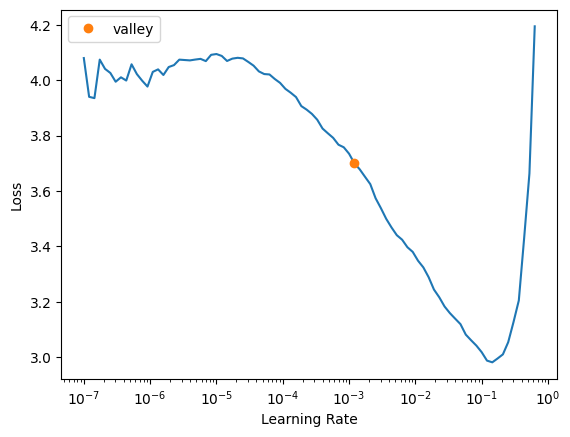

In [4]:
#Find optimal learning value instead of guessing
optimal_model = learn.lr_find()
print(optimal_model)
optimal_rate = optimal_model[0]

In [5]:
#Fine tune
learn.fine_tune(
    12, #epochs (# of trials
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', patience=3), #Stops training epochs if valid_loss begins dropping
        SaveModelCallback(monitor='valid_loss', fname='best_model') #Saves the best model if training stops
    ],
    base_lr = optimal_rate)

epoch,train_loss,valid_loss,accuracy,time
0,1.606812,1.061439,0.603599,04:39


Better model found at epoch 0 with valid_loss value: 1.0614391565322876.


epoch,train_loss,valid_loss,accuracy,time
0,0.859036,0.624866,0.709968,08:19
1,0.655251,0.533406,0.733272,08:15
2,0.511561,0.497501,0.739963,08:18
3,0.409564,0.474163,0.746654,08:24
4,0.380071,0.476487,0.748039,08:15
5,0.347007,0.484143,0.748962,08:19
6,0.321791,0.468419,0.752192,08:23
7,0.319261,0.468856,0.754499,08:23


Better model found at epoch 0 with valid_loss value: 0.6248663663864136.
Better model found at epoch 1 with valid_loss value: 0.5334060788154602.
Better model found at epoch 2 with valid_loss value: 0.4975009560585022.
Better model found at epoch 3 with valid_loss value: 0.4741629362106323.
Better model found at epoch 6 with valid_loss value: 0.46841853857040405.


KeyboardInterrupt: 

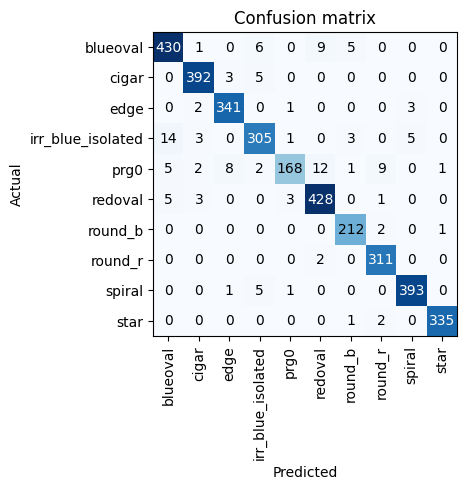

In [8]:
#Evaluate model with confusion matrix (not necessary but useful visual)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [9]:
#Save classifier
learn.export('full_model2.pkl')

# Import Model and Full Dataset Test

If model is already created, skip to this point to import and run on dataset.

In [ ]:
#Load in learner
learn = load_learner('full_model2.pkl')
dls = learn.dls
print("Model loaded.")

In [26]:
#Path to large dataset
# full_dataset = Path('ims')
full_dataset = Path('small_test_ims')
image_files = list(full_dataset.iterdir())

test_dls = learn.dls.test_dl(image_files, bs=256, num_workers=24, pin_memory=True) #This is a good point to edit the aspects of the model before testing

In [27]:
#This part just ensures that the model is actually mounted to utilize CUDA cores in the GPU
learn.to(torch.device('cuda'))

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06,

In [28]:
#Ensure model is in evaluation mode
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06,

### Run model on dataset

In [55]:
import torch.nn.functional as F

def temperature_softmax(logits, T=0.5):
    return F.softmax(logits / T, dim=1)

# Get raw logits from your model
preds, _ = learn.get_preds(dl=test_dls)

# Try with a temperature
probs_temp = temperature_softmax(preds, T=0.28)

# Save probabilities along with class predictions
predicted_classes = [learn.dls.vocab[i] for i in probs_temp.argmax(dim=1)]
probs_list = probs_temp.tolist()  # Convert tensor to a Python list


Image 0: max logit = 0.84861, avg others = 0.01682, delta = 0.83179
Image 1: max logit = 0.91033, avg others = 0.00996, delta = 0.90037
Image 2: max logit = 0.96724, avg others = 0.00364, delta = 0.96360


In [52]:
#original
# # Get predictions for the entire dataset
# preds, _ = learn.get_preds(dl=test_dls)

# # Convert predictions (logits) to probabilities
# probabilities = preds.softmax(dim=1)  # Applies softmax to get class probabilities

# # Save probabilities along with class predictions
# predicted_classes = [learn.dls.vocab[i] for i in probabilities.argmax(dim=1)]
# probs_list = probabilities.tolist()  # Convert tensor to a Python list


### Create Catalog with Probabilities for each image

In [56]:
# Create a DataFrame of probabilities with each column named after the corresponding class
prob_df = pd.DataFrame(probs_temp.numpy(), columns=learn.dls.vocab)

# Retrieve filenames directly from the test DataLoader's dataset (assuming items are file paths)
filenames = [Path(item).name for item in test_dls.dataset.items]

# Create the catalog DataFrame
catalog = pd.DataFrame({
    'filename': filenames,
    'predicted_class': predicted_classes
})

# Concatenate the probabilities: one column per galaxy type
catalog = pd.concat([catalog, prob_df], axis=1)

# Optional: round the probabilities for easier reading (e.g., 4 decimal places)
catalog.update(catalog.select_dtypes(float).round(8))

# Save the catalog to a CSV file
catalog.to_csv('catalog.csv', index=False)
print("Catalog saved as catalog.csv")


Catalog saved as catalog.csv
